<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "unsup_weight": 0.5,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Training result:
{
  "training_losses": [0.45707521235109655, 0.0837950803820164, 0.054103107982745736],
  "training_accuracies": [0.9025466893039049, 0.9891341256366724, 0.9911714770797962],
  "validation_accuracies": [0.9850340136054422, 0.9918367346938776, 0.9918367346938776],
  "update_steps": [93, 186, 279],
  "epochs": [1, 2, 3],
  "training_elapsed": 37.33326906699995
}


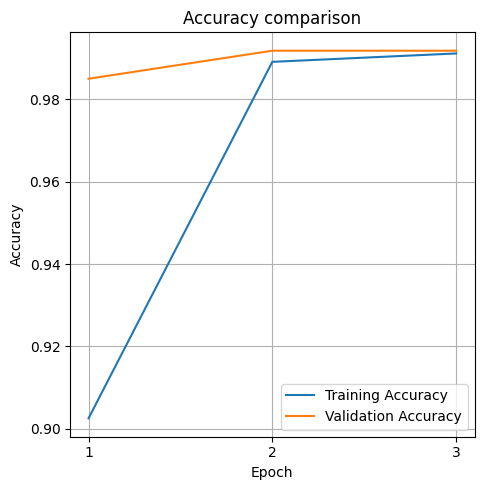

In [2]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams
%reload_ext autoreload
%autoreload 2

from training import TrainParams, AdamParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.2,  # 20 % of trainval set
    target_types="binary-category",
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=False,
        transform=None,
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

# Test model

In [3]:
from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(baseline_params), target_types="binary-category")
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")



Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/60b6c21956a312a2ec0d048230019a2c.pth (epoch 3)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 99.24%
